In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [3]:
from thinkdsp import decorate

Exercise 1

A sawtooth signal has a waveform that ramps up linearly from -1 to 1, then drops to -1 and repeats. See http://en.wikipedia.org/wiki/Sawtooth_wave
Write a class called SawtoothSignal that extends Signal and provides evaluate to evaluate a sawtooth signal.
Compute the spectrum of a sawtooth wave. How does the harmonic structure compare to triangle and square waves?

利用三角波

In [2]:
from thinkdsp import Sinusoid
from thinkdsp import normalize, unbias
import numpy as np

class SawtoothSignal(Sinusoid):
    """Represents a sawtooth signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

放出聲音及畫出wave

In [10]:
sawtooth = SawtoothSignal().make_wave(duration=0.5, framerate=40000)
sawtooth.make_audio()

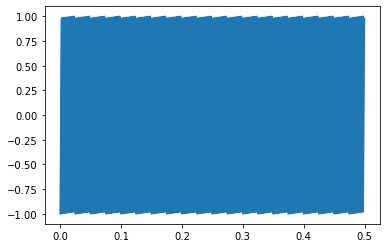

In [9]:
sawtooth.plot()

In [ ]:
製作頻譜

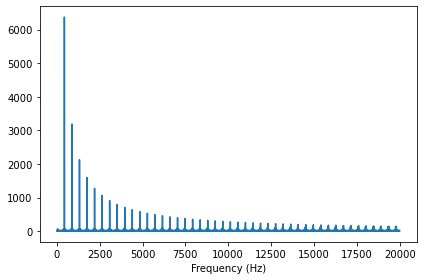

In [6]:
sawtooth.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

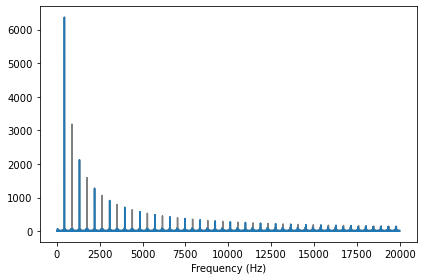

In [11]:
from thinkdsp import SquareSignal

sawtooth.make_spectrum().plot(color='gray')
square = SquareSignal(amp=0.5).make_wave(duration=0.5, framerate=40000)
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

灰色為鋸齒波，藍色為三角波，從圖中發現三角波的下降速度較鋸齒波快。

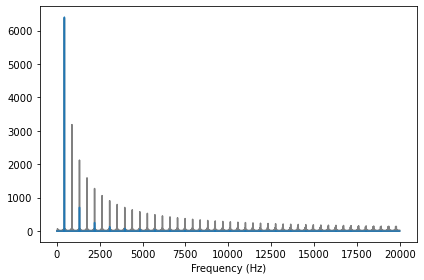

In [12]:
from thinkdsp import TriangleSignal

sawtooth.make_spectrum().plot(color='gray')
triangle = TriangleSignal(amp=0.79).make_wave(duration=0.5, framerate=40000)
triangle.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

In [ ]:
三角波下降的比例大約為1/f**2，而鋸齒波下降的比例大約為1/f

Exercise 2

Make a square signal at 1500 Hz and make a wave that samples it at 10000 frames per second. If you plot the spectrum, you can see that most of the harmonics are aliased. When you listen to the wave, can you hear the aliased harmonics?

In [13]:
square = SquareSignal(1500).make_wave(duration=0.5, framerate=10000)

轉換成頻譜圖

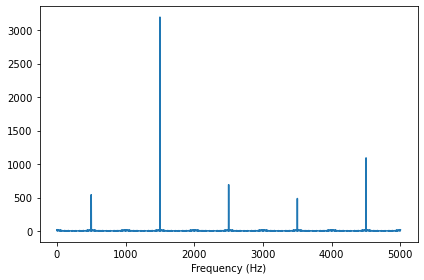

In [14]:
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

You can see the fundamental at 1500 Hz and the first harmonic at 4500 Hz, but the second harmonic, which should be at 7500 Hz, is aliased to 2500 Hz.
The third harmonic, which should be at 10500 Hz, would get aliased to -500 Hz, but that gets aliased again to 500 Hz.
And the 4th harmonic, which should be at 13500 Hz, ends up at 3500 Hz.
The 5th harmonic, which should be at 16500 Hz, ends up at 1500 Hz, so it contributes to the fundamental.
The remaining harmonics overlap with the ones we've already seen.
When you listen to the wave, the fundamental pitch you perceive is the alias at 500 Hz.

In [15]:
square.make_audio()

與頻率500Hz的波相比更加明顯

In [16]:
from thinkdsp import SinSignal

SinSignal(500).make_wave(duration=0.5, framerate=10000).make_audio()

Exercise 3

If you have a spectrum object, spectrum, and print the first few values of spectrum.fs, you’ll see that the frequencies start at zero. So spectrum.hs[0] is the magnitude of the component with frequency 0. But what does that mean?
Try this experiment:
Make a triangle signal with frequency 440 and make a Wave with duration 0.01 seconds. Plot the waveform.
Make a Spectrum object and print spectrum.hs[0]. What is the amplitude and phase of this component?
Set spectrum.hs[0] = 100. Make a Wave from the modified Spectrum and plot it. What effect does this operation have on the waveform?

三角波圖

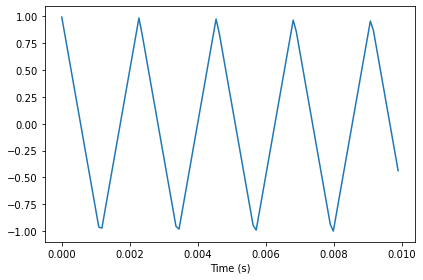

In [17]:
triangle = TriangleSignal().make_wave(duration=0.01)
triangle.plot()
decorate(xlabel='Time (s)')

第一個頻譜的元素相當複雜且趨近於0

In [18]:
spectrum = triangle.make_spectrum()
spectrum.hs[0]

(1.0436096431476471e-14+0j)

加上 zero-frequency component

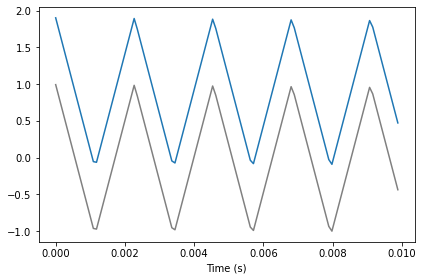

In [19]:
spectrum.hs[0] = 100
triangle.plot(color='gray')
spectrum.make_wave().plot()
decorate(xlabel='Time (s)')

The zero-frequency component is the total of all the values in the signal, as we'll see when we get into the details of the DFT. If the signal is unbiased, the zero-frequency component is 0. In the context of electrical signals, the zero-frequency term is called the DC offset; that is, a direct current offset added to an AC signal.

Exercise 4

Write a function that takes a Spectrum as a parameter and modifies it by dividing each element of hs by the corresponding frequency from fs. Test your function using one of the WAV files in the repository or any Wave object.
Compute the Spectrum and plot it.
Modify the Spectrum using your function and plot it again.
Make a Wave from the modified Spectrum and listen to it. What effect does this operation have on the signal?

function

In [20]:
def filter_spectrum(spectrum):
    """Divides the spectrum through by the fs.
    
    spectrum: Spectrum object
    """
    # avoid division by 0
    spectrum.hs[1:] /= spectrum.fs[1:]
    spectrum.hs[0] = 0

三角波

In [21]:
wave = TriangleSignal(freq=440).make_wave(duration=0.5)
wave.make_audio()

前後對比一下，過濾後的為灰色

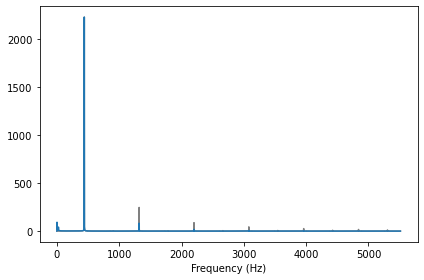

In [22]:
spectrum = wave.make_spectrum()
spectrum.plot(high=10000, color='gray')
filter_spectrum(spectrum)
spectrum.scale(440)
spectrum.plot(high=10000)
decorate(xlabel='Frequency (Hz)')

放出過濾後音訊

In [23]:
filtered = spectrum.make_wave()
filtered.make_audio()

Exercise 5

The triangle and square waves have odd harmonics only; the sawtooth wave has both even and odd harmonics. The harmonics of the square and sawtooth waves drop off in proportion to  1/𝑓 ; the harmonics of the triangle wave drop off like  1/𝑓2 . Can you find a waveform that has even and odd harmonics that drop off like  1/𝑓2 ?
Hint: There are two ways you could approach this: you could construct the signal you want by adding up sinusoids, or you could start with a signal that is similar to what you want and modify it.

從鋸齒波開始

In [24]:
freq = 500
signal = SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

畫出頻譜後，下降看起來為1/f

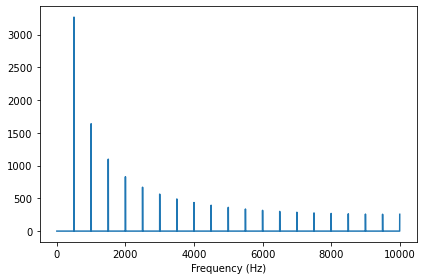

In [25]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

再除以一個f變為1/f**2

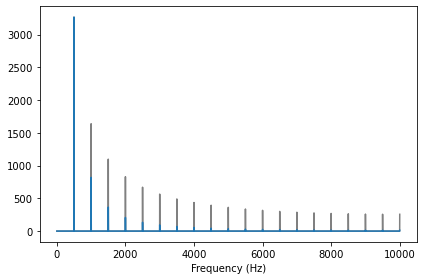

In [26]:
spectrum.plot(color='gray')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

In [27]:
wave = spectrum.make_wave()
wave.make_audio()

波型圖

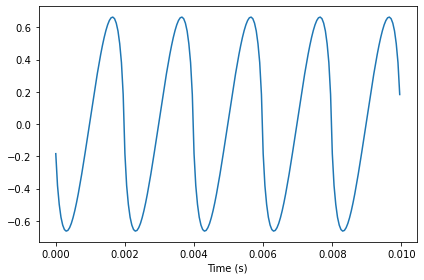

In [28]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

另一種方法將一系列的cosSignal相加

In [29]:
from thinkdsp import CosSignal

freqs = np.arange(500, 9500, 500)
amps = 1 / freqs**2
signal = sum(CosSignal(freq, amp) for freq, amp in zip(freqs, amps)) #zip 將兩個array->(freqs,amp)並兩兩相加
signal

跑出頻譜

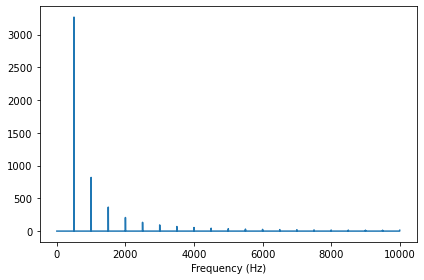

In [30]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

In [31]:
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

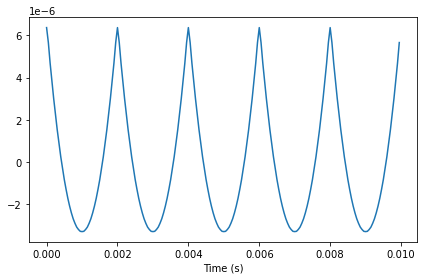

In [32]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

thinkdsp提供了拋物線波型

In [33]:
from thinkdsp import ParabolicSignal

wave = ParabolicSignal(freq=500).make_wave(duration=0.5, framerate=20000)
wave.make_audio()

波型如下

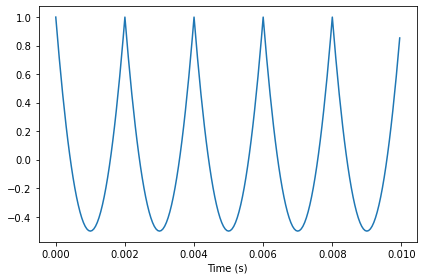

In [34]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

基數及偶數諧波的下降看起來為1/f**2

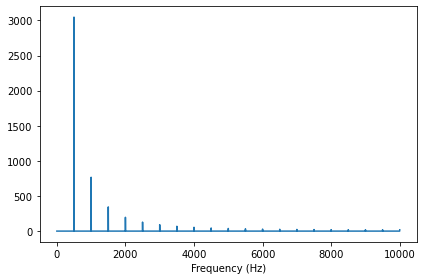

In [35]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')